In [1]:
import numpy as np
import pandas as pd
from itertools import chain
import colgen.display
import colgen.main
import colgen.models.truncnorm
import colgen.models.jump
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Compute survival probabilities with colgen

This tutorial presents how to compute survival probabilities over a collective level genealogy using colgen Bayesian network models. Here we present two models that are included in colgen: truncnorm and jump. See how they are defined in `colgen/models/truncnorm.py` if you want to add your own.

## Creating a mock tree to illustrate

We start by generating synthetic data for the tutorial with the following:

In [2]:
def generate_random_one_mutation(s1=0.5,s2=0.99,N=40,T=20,tmut=None):
    """Generate a fake tree with N collectives over T generations.
    
    The initial survival probability of collectives is s1.
    
    The survival probability of a collective is the same as its parent. Except for
    one collective at generation tmut that will mutate to survival s2.     
    """
    if tmut is None:
        tmut = T//3
        
    collectives = []
    collectives.append([dict(name="C{}_T00".format(n), 
                             parent='ROOT',  
                             trait=s1)
                        for n in range(N)])
    for t in range(1,T):
        
        for n in range(N):
            collectives[-1][n]['survived'] = np.random.random()<collectives[-1][n]['trait'] 
        
        survivors = [c for c in collectives[-1] if c['survived']]
        collectives.append([])

        for n in range(N):
            parent = np.random.choice(survivors)
            trait = parent['trait']
            collectives[-1].append(dict(
                name="C{}_T{:02}".format(n,t), 
                parent= parent['name'], 
                trait=parent['trait']))
        if t==tmut:
            collectives[-1][np.random.choice(range(N))]['trait'] = s2
            
    for n in range(N):
        collectives[-1][n]['survived'] = np.random.random()<collectives[-1][n]['trait']
        
    return pd.DataFrame(chain(*collectives))

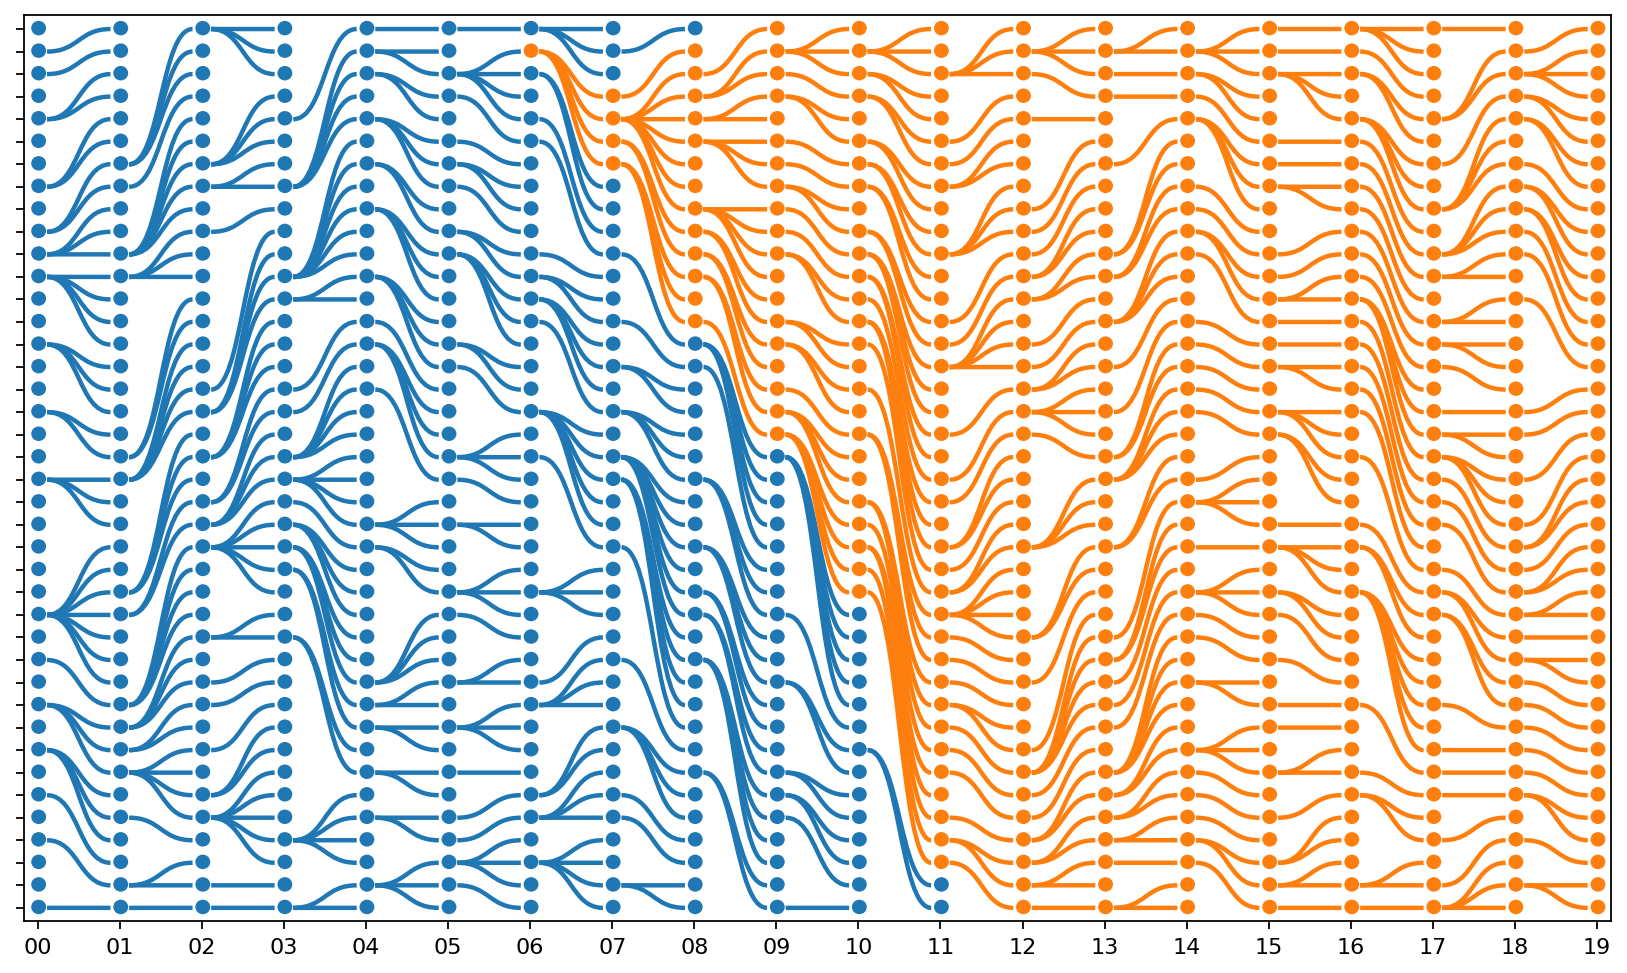

In [3]:
# Generate the mock dataset
np.random.seed(126) # This seed gives a nice tree
df = generate_random_one_mutation(s2=1)

# Add the column "extinct" to the fake dataset (required for the fit)
df['extinct'] = [not x for x in df['survived']] 

# Save the mock dataset
df.to_csv("mock_dataset.csv")

# Display the mock dataset
tree, df = colgen.display.load_df(df)
color = {x['name']: 'C0' if x['trait']==0.5 else 'C1' for k,x in df.iterrows()}
ax, scales = colgen.display.draw_tree(tree['branches'], tree['xinfo'], tree['yinfo'], color=color)

## Fit the truncnom model

In the truncnorm model, the survival probability is inherited following a truncated normal distribution with variance $\sigma$. The parameter $\sigma$ is optimised by the EM algorithm.

In [4]:
df_trunc, convergence_trunc = colgen.main.fit(df, 
                                              colgen.models.truncnorm, 
                                              sigma_range=(0.5,0,1),
                                              steps=20,
                                              max_em_steps=10)
print("Final value of sigma: {}".format(convergence_trunc.sigma.values[-1]))
df_trunc

Final value of sigma: 0.010253505541431902


name   parent  trait  survived  extinct  order  survival_estimate
0     C0_T00     ROOT    0.5      True    False    800              0.575
1     C1_T00     ROOT    0.5      True    False    799              0.575
2     C2_T00     ROOT    0.5      True    False    798              0.575
3     C3_T00     ROOT    0.5      True    False    797              0.575
4     C4_T00     ROOT    0.5     False     True    796              0.575
..       ...      ...    ...       ...      ...    ...                ...
795  C35_T19  C10_T18    1.0      True    False     16              0.975
796  C36_T19  C31_T18    1.0      True    False     33              0.975
797  C37_T19   C1_T18    1.0      True    False     23              0.975
798  C38_T19  C19_T18    1.0      True    False      4              0.975
799  C39_T19   C4_T18    1.0      True    False     35              0.975

[800 rows x 7 columns]

[Text(0.5, 1.0, 'Truncnorm model - survival probabilities')]

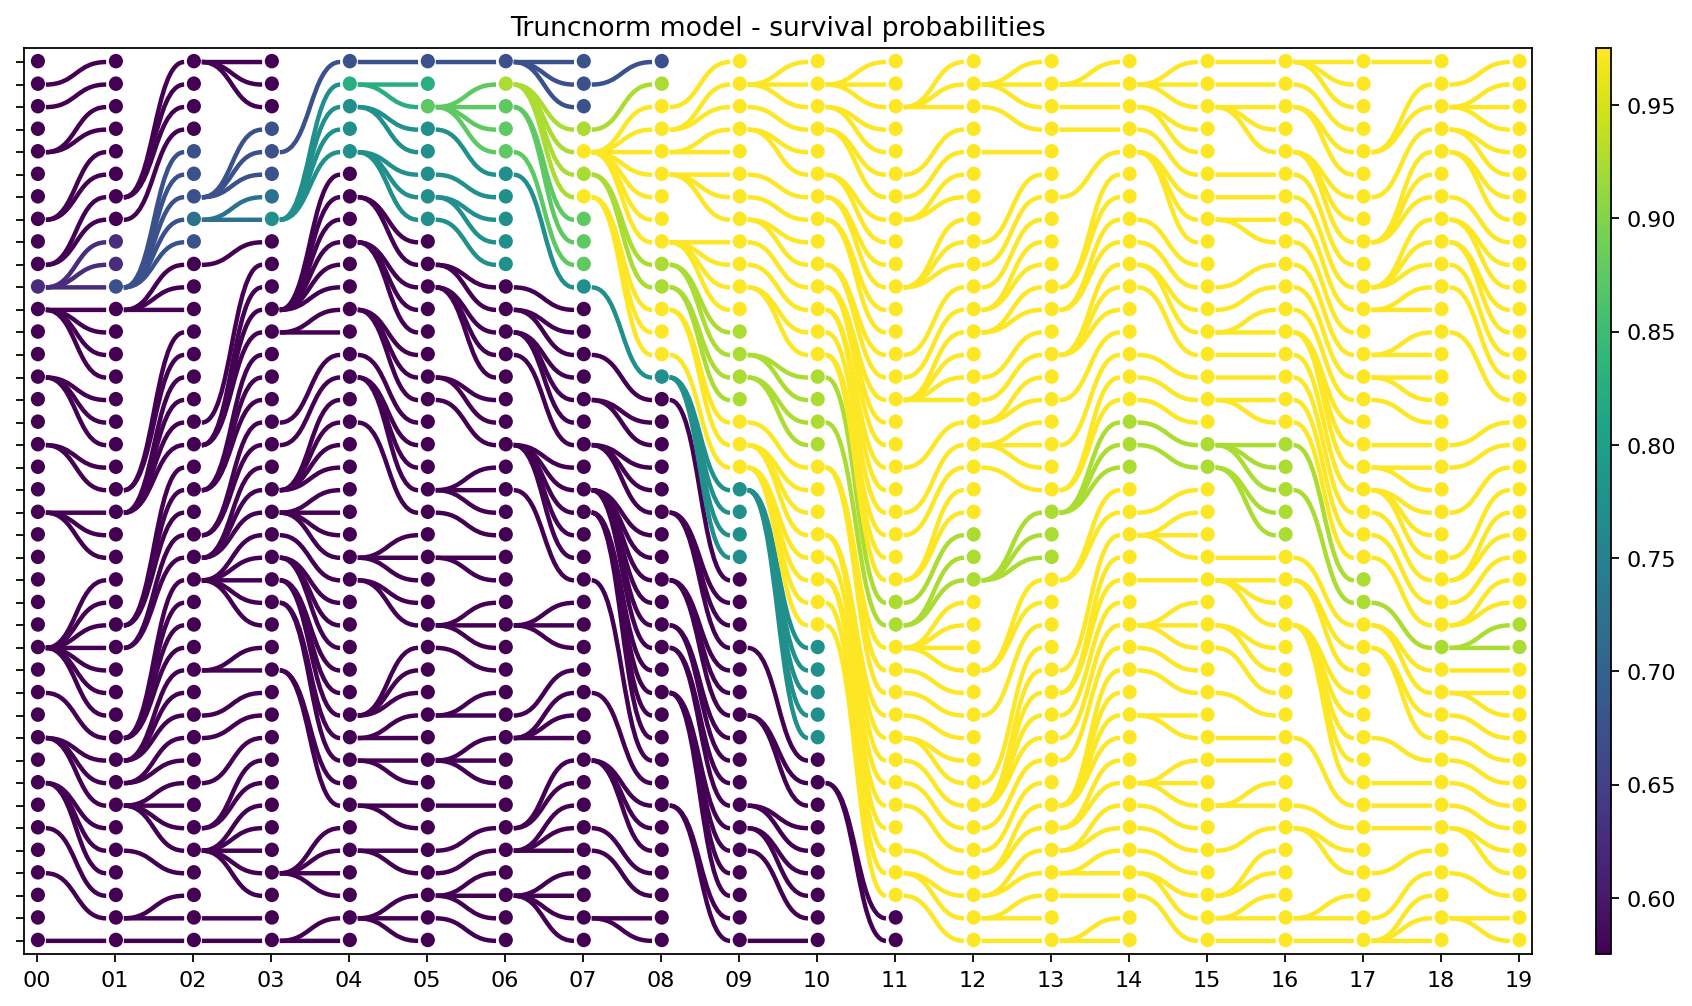

In [5]:
# Plot the result of the fit
color = df_trunc.set_index('name')['survival_estimate'].to_dict()
ax, scales = colgen.display.draw_tree(tree['branches'],
                                      tree['xinfo'], 
                                      tree['yinfo'],
                                      color=color, colormap=True)
ax.set(title="Truncnorm model - survival probabilities")

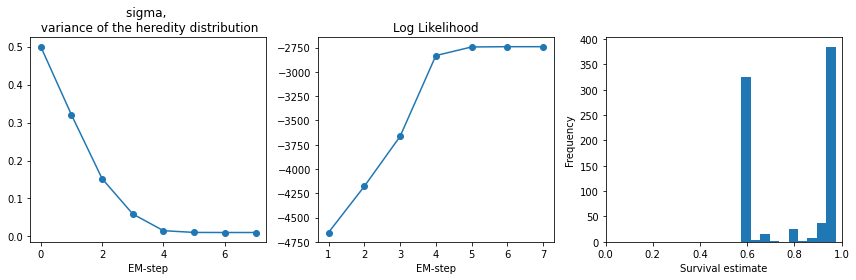

In [6]:
# Plot informations about the convergence, and the distribution of survival probabilities. 
fig,ax = plt.subplots(1,3, figsize=(12,4))
ax[0].scatter(np.arange(len(convergence_trunc.sigma)), convergence_trunc.sigma)
ax[0].plot(np.arange(len(convergence_trunc.sigma)), convergence_trunc.sigma)
ax[0].set(title='sigma, \n variance of the heredity distribution', xlabel='EM-step')
ax[1].scatter(np.arange(len(convergence_trunc.likelihood)), convergence_trunc.likelihood)
ax[1].set(title='Log Likelihood', xlabel='EM-step')
ax[1].plot(np.arange(len(convergence_trunc.likelihood)), convergence_trunc.likelihood)
ax[2].hist(df_trunc.survival_estimate)
ax[2].set(xlim=(0,1), xlabel='Survival estimate', ylabel='Frequency')
plt.tight_layout()

## Fitting the jump model

In the jump model, the survival probability is exactly inherited from the parent with probability $\sigma$ and uniform over [0,1] otherwise. The parameter $\sigma$ is optimised by the EM algorithm.

In [7]:
df_jump, convergence_jump = colgen.main.fit(df, 
                                            colgen.models.jump,
                                            sigma_range=(0.5,0,1),
                                            steps=20,
                                            max_em_steps=10)
print("Final value of sigma: {}".format(convergence_jump.sigma.values[-1]))
df_jump

Final value of sigma: 0.998683065388238


name   parent  trait  survived  extinct  order  survival_estimate
0     C0_T00     ROOT    0.5      True    False    800           0.473684
1     C1_T00     ROOT    0.5      True    False    799           0.473684
2     C2_T00     ROOT    0.5      True    False    798           0.473684
3     C3_T00     ROOT    0.5      True    False    797           0.473684
4     C4_T00     ROOT    0.5     False     True    796           0.473684
..       ...      ...    ...       ...      ...    ...                ...
795  C35_T19  C10_T18    1.0      True    False     16           0.947368
796  C36_T19  C31_T18    1.0      True    False     33           0.947368
797  C37_T19   C1_T18    1.0      True    False     23           0.947368
798  C38_T19  C19_T18    1.0      True    False      4           0.947368
799  C39_T19   C4_T18    1.0      True    False     35           0.947368

[800 rows x 7 columns]

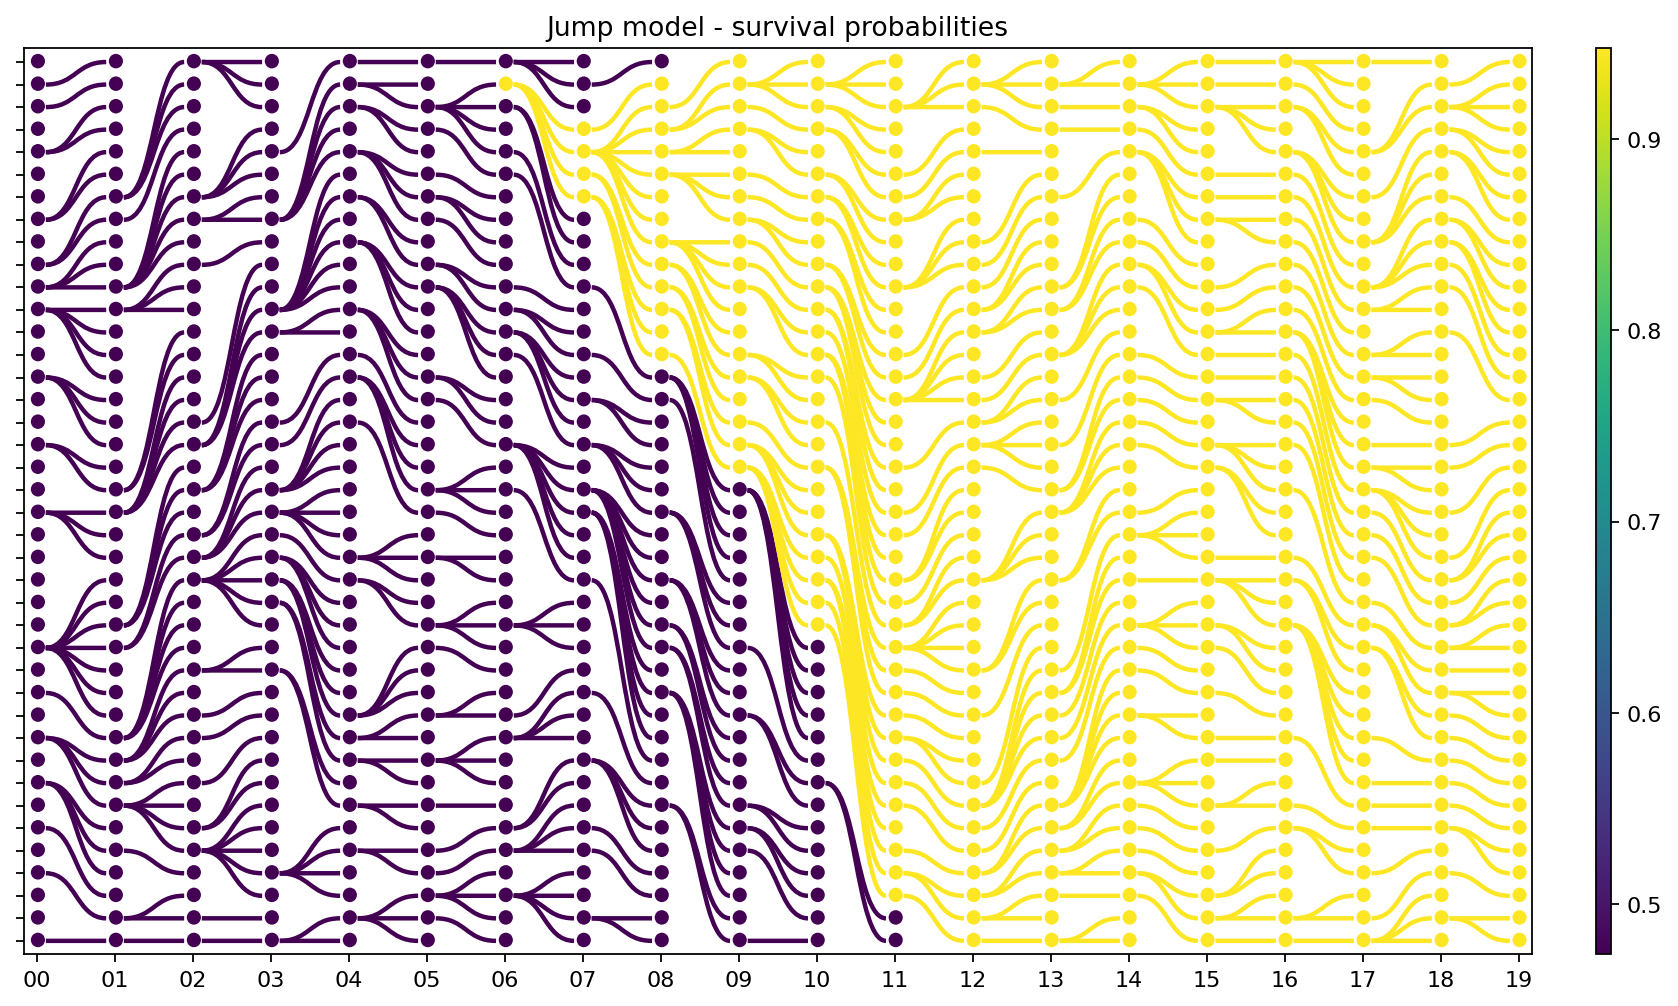

In [8]:
# Plot the result of the fit
color = df_jump.set_index('name')['survival_estimate'].to_dict()
ax, scales = colgen.display.draw_tree(tree['branches'],
                                      tree['xinfo'], 
                                      tree['yinfo'],
                                      color=color, colormap=True)
ax.set(title="Jump model - survival probabilities");

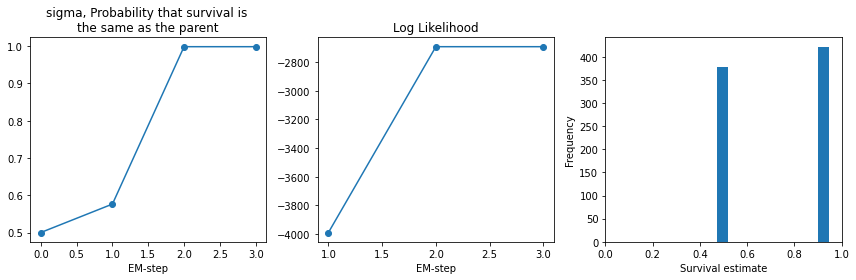

In [9]:
# Plot informations about the convergence, and the distribution of survival probabilities. 
fig,ax = plt.subplots(1,3, figsize=(12,4))
ax[0].scatter(np.arange(len(convergence_jump.sigma)), convergence_jump.sigma)
ax[0].plot(np.arange(len(convergence_jump.sigma)), convergence_jump.sigma)
ax[0].set(title='sigma, Probability that survival is \nthe same as the parent', xlabel='EM-step')
ax[1].scatter(np.arange(len(convergence_jump.likelihood)), convergence_jump.likelihood)
ax[1].set(title='Log Likelihood', xlabel='EM-step')
ax[1].plot(np.arange(len(convergence_jump.likelihood)), convergence_jump.likelihood)
ax[2].hist(df_jump.survival_estimate)
ax[2].set(xlim=(0,1), xlabel='Survival estimate', ylabel='Frequency')
plt.tight_layout()